
**PROYECTO CHURN** - **ENTIDAD BANCARIA**


*** Problemática a abordar**
> Una entidad bancaria, encuentra una perdida en la cantidad de clientes activos y solicita de nuestra intervención para prevenir las bajas.


*** Objetivo de la investigación**
> Debemos identificar, de ser posible cuales son los indicadores de alerta para aplicar una anticipada maniobra de retención sobre los clientes que potencialmente podríamos perder.
*   ¿Interviene una sola variable en la deserción o múltiples?
*   De ser múltiples variables, ¿Cuáles son y cómo afectan sus posibles combinaciones?¿Qué relación hay entre ellas?
*   ¿Podemos identificar cual es el grupo que más bajas nos representan?

*** Conformación del equipo**
> Para abordar este proyecto, reunión un equipo conformado por 3 profesionales:
*   Caligaris Gabriela – Data scientist, analista especializado de Producto
*   Churgovich Nahuel – Data scientist y developer 
*   Jerez Francisco – Data scientist, especialista en Supply chain

*** Fuente de dataset y criterios de selección**
> Para abordar la problemática, necesitamos mínimamente nos indiquen el género, edad, nacionalidad, score crediticio, antigüedad en la empresa, cantidad de productos obtenidos, salario, saldo, si posee tarjeta de crédito y si aún siguen siendo clientes.
> Al ser una empresa joven con una política de datos recientemente implementada, decidimos tomar un set de datos de una fuente externa confiable, con experiencia en datos y del mismo rubro que nuestro cliente. Luego de una ardua búsqueda dimos con un set de datos que cubría nuestras necesidades en https://www.kaggle.com/datasets/shubh0799/churn-modelling?datasetId=729058&sortBy=voteCount&language=Python .


# **Toma de datos**

In [3]:
# Importamos la libreria necesaria para obtener los datos 
import pandas as pd 

In [4]:
# Extraemos los datos de una URL. Por seguridad, los datos fueron guardados en un drive propio, el cual utilizaremos para almacenar nuetro set original.
df_original = pd.read_csv(r'https://docs.google.com/spreadsheets/d/e/2PACX-1vQQXsYNGUdaB6JViz_aMf9Ez5TyAJCKMxdkdCobFUfjMznvQs--DOIcGEFRvCOZEKdl_jHf-aHs223o/pub?output=csv')
# Realizamos una primera impresion para visualizar las primeras filas del set
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# **Limpieza y preparación de datos**

## Data Wrangling y EDA

In [5]:
# Duplicamos el set para asegurarnos de no modificar nada del original y solo manipular la copia.
df_limpio = df_original.copy()
# Seteamos el numero de cliente como indice
df_limpio = df_limpio.set_index('CustomerId')
# Borramos las columnas que no resultan utiles para el analisis que abordaremos
df_limpio = df_limpio.drop(['RowNumber','Surname'],axis=1)
df_limpio.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Variables resultantes a considerar para el estudio:

- **CustomerId:** Identificación del cliente.
- **CreditScore:** Calificación crediticia.
- **Geography:** Ubicación geográfica.
- **Gender:** Genero o sexo.
- **Age:** Edad.
- **Tenure:** Tiempo que el cliente ha estado con la entidad.
- **Balance:** Saldo de la cuenta del cliente.
- **NumOfProducts:** Cantidad de productos que posee en la entidad.
- **HasCrCard:** Si el cliente posee o no tarjeta de credito
- **IsActiveMember:** Si el cliente es un miembro activo de la entidad o no
- **EstimatedSalary:** Salario estimado percibido por los clientes
- **Exited:** Si el cliente abandonó o no la entidad.

<AxesSubplot:>

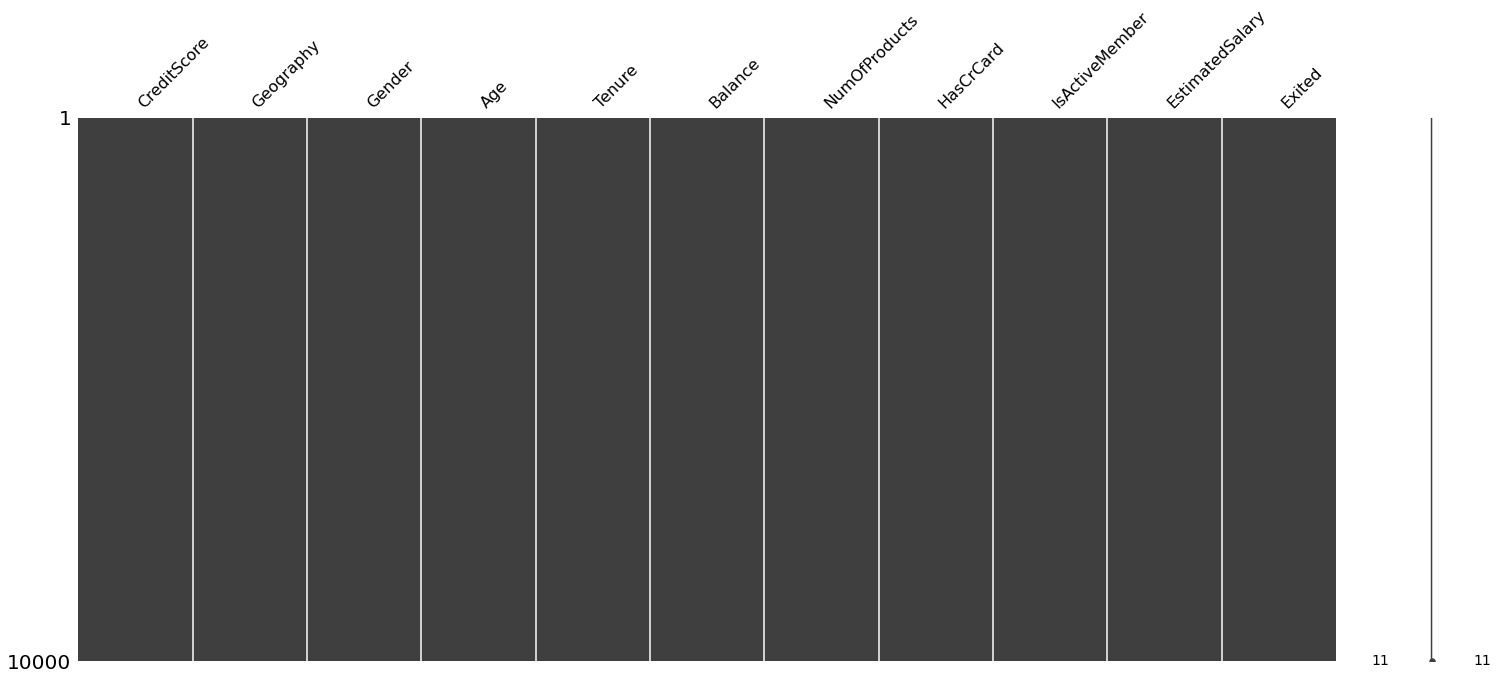

In [6]:
# Graficamos la existencia de datos nulos
!pip install missingno
import missingno as msno
msno.matrix(df_limpio)

Se comprueba mediante el gráfico que el data set no presenta datos nulos.

In [7]:
from pandas.api.types import is_numeric_dtype
# Creamos una funcion para obtener informacion estadistica para cada columna del dataframe
def obtenerInfo(df):  
  
  df_info = pd.DataFrame(columns=['cantRegistros', 'dato' , 'nulos', 'unicos','repetidos','esNumerico', 'cantDeCeros']) #creación de dataframe con columnas especificas
  for col in df: #loop de todas las variables del dataframe

      #obtención info de la columna
      data_series = df[col]
      #llenado de dataframe en las columnas iniciales
      df_info.loc[col] = [data_series.count(), data_series.dtype, data_series.isnull().sum(), data_series.nunique(),(data_series.count()-data_series.nunique()), is_numeric_dtype(data_series),(data_series == 0).sum()]

  #calculo el describe 
  df_describe = df.describe(include='all').T[['top', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
  #calculo sesgo y curtosis
  df_stats = pd.DataFrame([df.skew(), df.kurtosis()], index=['sesgo', 'curtosis']).T

  return pd.concat([df_info,pd.concat([df_describe, df_stats], axis=1)], axis=1).fillna('-')

In [8]:
# Hacemos uso de la funcion creada
df_info = obtenerInfo(df_limpio.copy())
df_info

C:\Users\nchur\AppData\Local\Temp/ipykernel_12936/336512644.py:16: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_stats = pd.DataFrame([df.skew(), df.kurtosis()], index=['sesgo', 'curtosis']).T


,cantRegistros,dato,nulos,unicos,repetidos,esNumerico,cantDeCeros,top,mean,std,min,25%,50%,75%,max,sesgo,curtosis
CreditScore,10000,int64,0,460,9540,True,0,-,650.5288,96.653299,350.0,584.0,652.0,718.0,850.0,-0.071607,-0.425726
Geography,10000,object,0,3,9997,False,0,France,-,-,-,-,-,-,-,-,-
Gender,10000,object,0,2,9998,False,0,Male,-,-,-,-,-,-,-,-,-
Age,10000,int64,0,70,9930,True,0,-,38.9218,10.487806,18.0,32.0,37.0,44.0,92.0,1.01132,1.395347
Tenure,10000,int64,0,11,9989,True,413,-,5.0128,2.892174,0.0,3.0,5.0,7.0,10.0,0.010991,-1.165225
Balance,10000,float64,0,6382,3618,True,3617,-,76485.889288,62397.405202,0.0,0.0,97198.54,127644.24,250898.09,-0.141109,-1.489412
NumOfProducts,10000,int64,0,4,9996,True,0,-,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0,0.745568,0.582981
HasCrCard,10000,int64,0,2,9998,True,2945,-,0.7055,0.45584,0.0,0.0,1.0,1.0,1.0,-0.901812,-1.186973
IsActiveMember,10000,int64,0,2,9998,True,4849,-,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0,-0.060437,-1.996747
EstimatedSalary,10000,float64,0,9999,1,True,0,-,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,0.002085,-1.181518


De la informacion obtenida podemos concluir en que el set de datos esta limpio y completo con informacion util.

In [9]:
# Creamos agrupaciones de variables para evitar disperciones en algunos analisis (esta celda de codigo puede verse afectada luego de dichos analisis)
df_archivoAgrupado = df_limpio.copy()
# Gracias a la funcion anterior sabemos que el rango etario es de 18 a 92 años
df_archivoAgrupado['AgeGroup'] = df_archivoAgrupado['Age'].apply(
    lambda x: 'Hasta 24' if x <=24 else 
     ('25 a 34' if(x>24 and x<=34) else 
     ('35 a 44' if(x>34 and x<=44) else 
     ('45 a 54' if(x>44 and x<=54) else 
     ('55 a 64' if(x>54 and x<=64) else 
     ('65 a 74' if(x>64 and x<=74) else 
     ('75 a 84' if(x>74 and x<=84) else    
      'Mayor de 84')))))))

# Gracias a la funcion anterior sabemos que el score varia entre 350 y 850
df_archivoAgrupado['CreditScoreGroup'] = df_archivoAgrupado['CreditScore'].apply(
    lambda x: 'Hasta 449' if x <=449 else 
     ('450 a 549' if(x>449 and x<=549) else 
     ('550 a 649' if(x>549 and x<=649) else 
     ('650 a 749' if(x>649 and x<=749) else      
      '750 a 850' ))))

# Gracias a la funcion anterior sabemos que el rango salarial es de 11 a 200.000
df_archivoAgrupado['SalaryGroup'] = df_archivoAgrupado['EstimatedSalary'].apply(
    lambda x: 'Hasta 9.999' if x <=9999 else 
     ('10.000 a 19.999' if(x>9999 and x<=19999) else 
     ('20.000 a 29.999' if(x>19999 and x<=29999) else 
     ('30.000 a 39.999' if(x>29999 and x<=39999) else 
     ('40.000 a 49.999' if(x>39999 and x<=49999) else 
     ('50.000 a 59.999' if(x>49999 and x<=59999) else 
     ('60.000 a 69.999' if(x>59999 and x<=69999) else 
     ('70.000 a 79.999' if(x>69999 and x<=79999) else 
     ('80.000 a 89.999' if(x>79999 and x<=89999) else 
     ('90.000 a 99.999' if(x>89999 and x<=99999) else 
     ('100.000 a 109.999' if(x>99999 and x<=109999) else 
     ('110.000 a 119.999' if(x>109999 and x<=119999) else 
     ('120.000 a 129.999' if(x>119999 and x<=129999) else 
     ('130.000 a 129.999' if(x>129999 and x<=139999) else 
     ('140.000 a 149.999' if(x>139999 and x<=149999) else 
     ('150.000 a 159.999' if(x>149999 and x<=159999) else 
     ('160.000 a 169.999' if(x>159999 and x<=169999) else 
     ('170.000 a 179.999' if(x>169999 and x<=179999) else 
     ('180.000 a 189.999' if(x>179999 and x<=189999) else 
      'Mas de 190.00')))))))))))))))))))

df_archivoAgrupado.head(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AgeGroup,CreditScoreGroup,SalaryGroup
CustomerId,,,,,,,,,,,,,,
15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,35 a 44,550 a 649,100.000 a 109.999
15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,35 a 44,550 a 649,110.000 a 119.999
15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,35 a 44,450 a 549,110.000 a 119.999
15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,35 a 44,650 a 749,90.000 a 99.999
15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,35 a 44,750 a 850,70.000 a 79.999
15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1,35 a 44,550 a 649,140.000 a 149.999
15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0,45 a 54,750 a 850,10.000 a 19.999
15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1,25 a 34,Hasta 449,110.000 a 119.999
15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0,35 a 44,450 a 549,70.000 a 79.999


# **Análisis  de datos**

In [10]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from seaborn import boxplot
import math
from pandas.api.types import is_numeric_dtype
!pip install sidetable
import sidetable
import warnings
warnings.filterwarnings("ignore")
from matplotlib.patches import Rectangle
!pip install plotly --upgrade
import plotly.express as px

## Univariado

Haremos el estudio univariado de las variables categoricas  respecto a la frecuencia  para entender su comportamiento:

In [11]:
#Frecuecia según país
df_archivoAgrupado.stb.freq(['Geography'])

,Geography,count,percent,cumulative_count,cumulative_percent
0,France,5014,50.14,5014,50.14
1,Germany,2509,25.09,7523,75.23
2,Spain,2477,24.77,10000,100.00


Se observa que la mitad de los clientes se concentran en Francia, mientras que el 50% restante son de Alemania y España en proporciones similares

In [12]:
#Frecuecia según genero
df_archivoAgrupado.stb.freq(['Gender'])

,Gender,count,percent,cumulative_count,cumulative_percent
0,Male,5457,54.57,5457,54.57
1,Female,4543,45.43,10000,100.00


Si bien la proporción de hombres es levemente superior a la de mujeres (55% vs 45% respectivamente), podría decirse que la distribución de clientes por género es pareja 

In [13]:
#Frecuecia según permanencia
df_archivoAgrupado.stb.freq(['Tenure'])

,Tenure,count,percent,cumulative_count,cumulative_percent
0,2,1048,10.48,1048,10.48
1,1,1035,10.35,2083,20.83
2,7,1028,10.28,3111,31.11
3,8,1025,10.25,4136,41.36
4,5,1012,10.12,5148,51.48
5,3,1009,10.09,6157,61.57
6,4,989,9.89,7146,71.46
7,9,984,9.84,8130,81.30
8,6,967,9.67,9097,90.97
9,10,490,4.90,9587,95.87


No hay patrón marcado de permanencia, los datos se distribuyen en forma similar en los años, aunque los extremos (0 y 10 años) son los menos frecuentes.

Para continuar analizamos el conjunto de variables categoricas y además le sumamos algunas numericas para visualizar un poco más en detalle el comportamiento de los datos

In [16]:
def plotFrequency(cat_columns, data, twodim=False):
    '''Graficos de variables categoricas evaluando su frecuencia '''
    
    fig, axes = plt.subplots(math.ceil(len(cat_columns) / 3), 3, figsize=(20, 12)) # genero el lienzo determinando la cantidad de filas en base a la cantidad de categoricas
    
    axes = axes.flatten() # hago un flatten para que queden todas en una dimension para poder realizar una agrupacion de datos en el loop proximo

    for ax, cat in zip(axes, cat_columns):

        if not twodim:
          sns.countplot(data[cat], palette='PuBu', ax=ax).set(title=f'Frecuencia de la variable {cat}')
        
        else:
          if cat != 'Exited':
            sns.countplot(x=cat,
                            data=data,
                            hue='Exited',
                            palette='PuBu',
                            ax=ax)
            ax.legend(title='Exited?',
                        loc='upper right',
                        labels=['No', 'Yes'])

        total = float(len(data[cat]))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="bottom")

In [19]:
help(plt)

Help on module matplotlib.pyplot in matplotlib:

NAME
    matplotlib.pyplot

DESCRIPTION
    `matplotlib.pyplot` is a state-based interface to matplotlib. It provides
    a MATLAB-like way of plotting.
    
    pyplot is mainly intended for interactive plots and simple cases of
    programmatic plot generation::
    
        import numpy as np
        import matplotlib.pyplot as plt
    
        x = np.arange(0, 5, 0.1)
        y = np.sin(x)
        plt.plot(x, y)
    
    The object-oriented API is recommended for more complex plots.

FUNCTIONS
    acorr(x, *, data=None, **kwargs)
        Plot the autocorrelation of *x*.
        
        Parameters
        ----------
        x : array-like
        
        detrend : callable, default: `.mlab.detrend_none` (no detrending)
            A detrending function applied to *x*.  It must have the
            signature ::
        
                detrend(x: np.ndarray) -> np.ndarray
        
        normed : bool, default: True
            If `

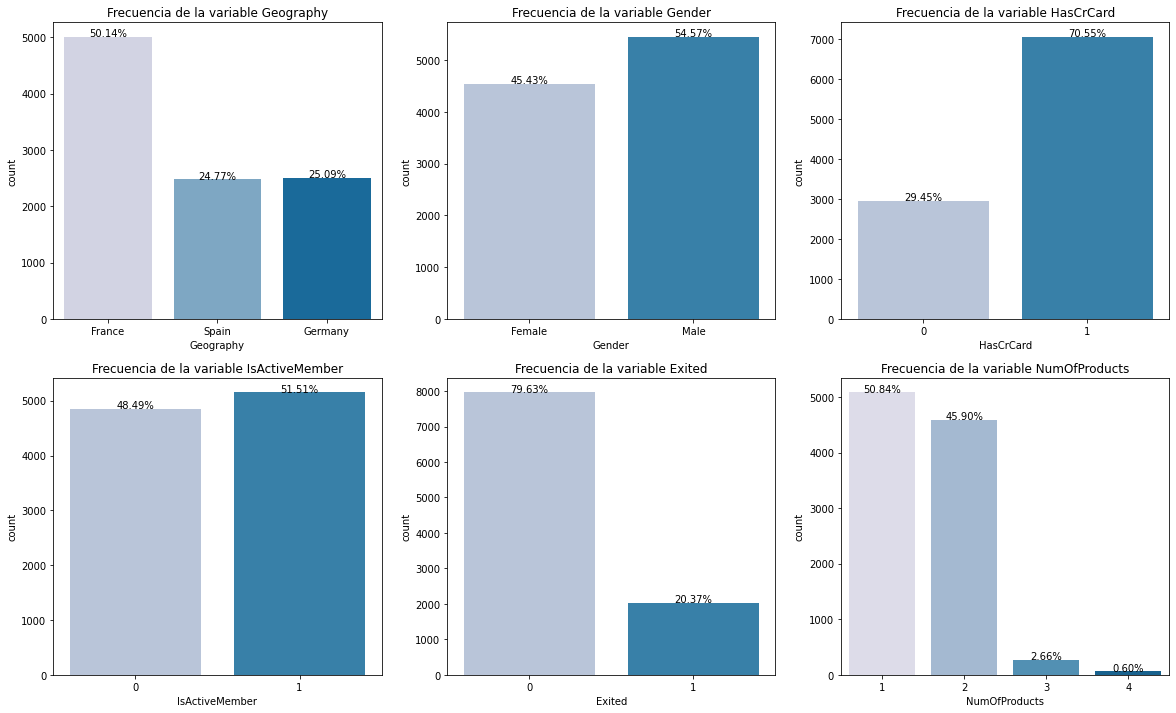

In [17]:
cat_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited','NumOfProducts']
plotFrequency(cat_columns , df_archivoAgrupado);

En los gráficos, se puede verificar lo ya analizado en las tablas de frecuencia para las variables Geography y Gender e identificar que:
- La mayoría de los clientes poseen tarjeta de crédito (+70%)
- No hay diferencias significativas entre la cantidad de clientes activos y no activos
- El 20% de los clientes se ha ido/salido
- El 90% de los clientes ha adquirido 2 productos o menos

## Bivariado

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
import pandas_profiling

Para este analisis utilizaremos el data profiling para observar un panorama general de la relación entre variables y exponer algunos gráficos a partir de ello.

In [ ]:
#Data Profiling
profile = pandas_profiling.ProfileReport(df_archivoAgrupado)
profile

## Gráficos Relaciíon entre variables - Bivariado

In [ ]:
plt.rcParams['figure.figsize'] = (23, 23)

sns.heatmap(df_archivoAgrupado.corr(), annot = True, cmap='PuBu')
plt.title('Heatmap for the Dataset', fontsize = 20)
plt.show()

No se observa una relación muy fuerte entre ninguna de las variables a simple vista.

In [ ]:
plt.rcParams['figure.figsize'] = (7, 7)
sns.boxplot(df_archivoAgrupado['NumOfProducts'],df_archivoAgrupado['Age'], palette = 'PuBu')
plt.title('Relación entre edad y cantidad de productos', fontsize = 20)
plt.show()

Para una primera vista, tomamos la edad de los clientes en relación a la cantidad de productos de la entidad bancaria que poseen, y se observa que para los rangos de edad entre 30 y 40 años tienen menos productos respeto a clientes en un rango de 45 a 60 años. Se observa tambíen una **gran cantidad de outliers** para **1 y 2 productos** adquiridos con edades bastante avanzadas.

In [ ]:
sns.set_theme(style='dark')
sns.catplot(data= df_archivoAgrupado, kind='violin', x='Exited', y='EstimatedSalary', hue='Gender',palette="PuBu", split=True)
plt.xlabel('Abandono')
plt.ylabel('Salario Promedio')
plt.title('Salario vs Abandono', fontsize=20)
plt.show()

En el gráfico se observa una **mayor tasa de abandono de mujeres** la entidad respecto a hombres y que, además, **percibian un sueldo promedio más alto**. Es importante tener en cuenta una acción orientada a este grupo y ver la forma de poder mantenerlas dentro de la entidad.

## Multivariado

Para este analisis partiremos con un analisis separado de la variable **"Genero"** que nos permita entender el comportamiento de la misma

In [ ]:
# Realizamos una division del dataset por genero entendiendo que posiblemente tengamos una observacion mas detallada si abordamos el set con esta distribucion.
df_female = df_archivoAgrupado[(df_archivoAgrupado["Gender"] == "Female")]
df_male = df_archivoAgrupado[(df_archivoAgrupado["Gender"] == "Male")]

In [ ]:
fig1 = px.scatter(df_female, x="CreditScore", y="Age",size='Balance',size_max = 25,symbol='Exited',color='Exited',trendline="ols", title ='Relacion entre Score y edad en Mujeres')
fig1.update_layout(autosize=False,width=2000,height=800)
fig1.update(layout_coloraxis_showscale=False)
fig2 = px.scatter(df_male, x="CreditScore", y="Age",size='Balance',size_max = 25,symbol='Exited',color='Exited',trendline="ols", title ='Relacion entre Score y edad en Hombres')
fig2.update_layout(autosize=False,width=2000,height=800)
fig2.update(layout_coloraxis_showscale=False)
fig1.show()
fig2.show()

De estos gráficos podemos concluir a simple vista que luego de los 50 años se dan muchas salidas de la empresa, sin importar el género. Por otro lado, concluimos que las mujeres más activas se encuentran entre los 25 y 45 años, dentro de un score de 650 a 700. Para el caso de los hombres entendemos que el cuadrante comparte el grupo etario, pero se amplía levemente en el score hacia los 600.

##Gráficos Relación entre variables - Multivariado

In [ ]:
sns.boxplot(data=df_archivoAgrupado, x='NumOfProducts', y='Age', hue='Geography', palette='PuBu')
plt.title('Relación entre edad y cantidad de productos', fontsize = 20)
plt.show()

Se le agrega la variable geográfica al analisis de edad vs produtos planteado anteriormente donde **la tendencia se mantiene en rangos de edad más altos con mayor cantidad de productos adquiridos**. Se observa también que en Alemania los rangos de edad son bastante similares para todos los tipos de producto.

In [ ]:
sns.barplot(x="Tenure", y="NumOfProducts", hue="Gender", data=df_archivoAgrupado)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Productos adquiridos vs Años de permanencia', fontsize= 20)
plt.xlabel('Permanencia')
plt.ylabel('N° de productos')
plt.show()

Identificamos que se repite **la superioridad en la cantidad de productos a favor de las mujeres** más allá de la cantidad de tiempo que están en la empresa. También concluimos que a partir del segundo año tenemos un incremento en la cantidad de productos adquiridos, pero con una caída importante hacia el tercer año acentuada solo para los hombres.

In [ ]:
cat_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember','NumOfProducts']
plotFrequency(cat_columns , df_archivoAgrupado, True);

De los gráficos, se puede inferir que:
- Casi el 50% de los clientes de Alemania se han ido vs el 20% de los demás países
- Hay mayor tasa de abandono de mujeres en la entidad que respecto a hombres
- El 25% de los que tienen tarjeta de crédito han abandonado la compañía
- El 40% de los clientes que consumieron un producto se han ido, aunque prácticamente el 100% de los que consumieron 3 y 4 también.